In [279]:
import numpy as np
from numpy.fft import fft2, ifft2
from PIL import Image, ImageOps, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import measure
from collections import defaultdict
import cv2
from scipy.ndimage import convolve

# OCR - Optical Character Recognition

Spis treści:
- ...
- ...

# Założenia

- Tekst składa się z małych liter alfabetu łacińskiego oraz cyfr.
- Na obrazie występuje jeden typ i rozmiar czcionki.
- Występują znaki przestankowe:   .  ,  !  ?
- Tekst składa się z wielu linii.
- Tekst może być obrócony.
- Program pownien zwracać tekst wraz ze znakami białymi i znakami nowej linii.
- Program powinien zliczać liczbę wystąpień każdego znaku.

TODO:
- SZERYFOWE I NIE SZERYFOWE -> porównaj
- może raportować % poprawności dla predefiniowanych testów
- operacja splotu i dft
- redukcja szumu
- obrót
- czytanie lini i spacji

# Wczytywanie obrazu

Obraz wczytuję za pomocą biblioteki PIL i konwertuję go na skalę szarości

In [61]:
def load_image(filepath, invert=True):
    if invert:
        return ImageOps.invert(Image.open(filepath).convert('L'))
    return Image.open(filepath).convert('L')

# Tworzenie obrazu z tekstem

Do utworzenia obrazu z tekstem używam biblioteki PIL. Tworzę obraz o wymiarach 1000x1000 pikseli, a następnie dodaję na nim tekst.  
Przy ewentualnych argumentach obraz może być obrócony o dany kąt i/lub nałożony na niego szum.

In [126]:
def draw_text(text, font_name, font_size, rotate=0, noise=0):
    def add_noise(img, noise):
        img = np.array(img)
        noise = np.random.normal(0, noise, img.shape)
        noisy = img + noise
        noisy = np.clip(noisy, 0, 255)
        return Image.fromarray(noisy.astype(np.uint8))
    font = ImageFont.truetype("./{}.ttf".format(font_name), font_size)
    img = Image.new('L', (1000, 1000), color='black')
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), text, font=font, fill='white')
    rotated = img.rotate(rotate)
    cropped = rotated.crop(rotated.getbbox())
    reversed = ImageOps.invert(cropped)
    padded = ImageOps.expand(reversed, border=10, fill='white')
    noised = add_noise(padded, noise)
    return noised

# Obrót obrazu

Wykrywam najmniejszy prostokąt, który zawiera tekst i obracam go tak, aby był prostokątem o bokach równoległych do osi układu współrzędnych:
- jeśli jest skierowany w górę to ustawiam kąt na przeciwny
- jeśli jest skierowany w dół to ustawiam kąt na dopełnienie 90 stopni

In [64]:
def rotate_image(img):
    gray = np.array(img)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    p1, p2, angle = cv2.minAreaRect(coords)

    if p1[1] < p2[1]:
        angle = -angle
    else:
        angle = 90 - angle
    return img.rotate(angle, expand=1, fillcolor=255, resample=Image.BICUBIC)

# Usuwanie szumu

Do usuwania szumu wykorzystuję interpolację dwuwymiarową. Dla każdego piksela obliczam średnią z jego sąsiadów z otoczenia o rozmiarze 3x3 o poniżych współczynnikach.

In [278]:
def remove_noise(image):
    display(image)
    img = np.array(image)
    kernel = np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]], dtype=np.float64)
    kernel /= kernel.sum()
    smooth_data = convolve(img, kernel)
    return Image.fromarray(smooth_data.astype(np.uint8))

# Wczytywanie czcionek

Do mojego programu przygotowałem dwa zestawy czcionek: 
- szeryfową (serif)
- nie szeryfową (sans-serif)  

Każdy zestaw zawiera 26 liter alfabetu łacińskiego, 4 znaki przestankowe, 10 cyfr oraz obraz wszystkich znaków w jednym pliku.  
Wczytuję je z plików .png, konwertuję na skalę szarości i zapisuję w tablicy numpy za pomocą powyżej zdefiniowanej funkcji.

In [65]:
def load_font2(fontname, fontsize):
    return ImageFont.truetype(f'fonts/{fontname}.ttf', fontsize)

xx = load_font2('times-new-roman', 60)



def load_fonts():
    fonts = {font: {char[:-4]: load_image(f'./fonts/{font}/{char}') for char in os.listdir(f'./fonts/{font}')} for font in os.listdir('fonts')}
    key_mappings = [('exclamation-mark', '!'), ('question-mark', '?'), ('dot', '.'), ('comma', ',')]
    for _, font in fonts.items():
        for old_key, new_key in key_mappings:
            font[new_key] = font[old_key]
            del font[old_key]
    return fonts

# Dodanie wszystkich znaków do obrazu 

Aby mieć pewność, że znak został rozpoznany, dodaję do obrazu wszystkie wzorce znaków z wybranego zestawu czcionek, które będą porównywane z obrazem wejściowym. Dzięki temu dodane wzorce powinny mieć największe wartości korelacji, właśnie z tą wartością będę porównywał obraz wejściowy.

In [66]:
def add_char_patterns(image, font, fontsize=9):
    #patterns = make_image(''.join([chr(i) for i in range(33, 127)]), font, fontsize)
    patterns = font['all']
    result = Image.new('L', (max(image.width, patterns.width), image.height + patterns.height), 0)
    result.paste(image, (0, 0))
    result.paste(patterns, (0, image.height))
    return np.array(result)

# Korelacja

In [67]:
def correlation(image, sample):
    return np.real(ifft2(np.multiply(fft2(np.array(image)), fft2(np.rot90(sample, 2), np.array(image).shape))))

# Zaznaczanie znalezionych znaków

In [68]:
def highlight_matches(image, pattern, char, matches, ratio=10):
    fig, ax = plt.subplots(figsize=(image.shape[0]//ratio, image.shape[1]//ratio))
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{char} - {len(matches)} found')
    for x, y in matches:
        ax.add_patch(patches.Rectangle((y, x), -pattern.shape[1], -pattern.shape[0], edgecolor='r', facecolor='none'))
    plt.show()

# Kolejność wykrywania znaków

Kolejność wykrywania znaków ustalam na podstawie odwrotnej listy liczby wykrytych znaków w obrazie zawierającym wszystkie znaki - skoro z daną pewnością wykryłem pewien znak więcej niż jeden raz to jest większa szansa na pomylenie go w obrazie wejściowym.

Głównym powodem takiego stanu jest podobieństwo niektórych znaków, np. 'i' i 'l', oraz zawieranie się niektórych znaków w innych, np. 'c' w 'e'.

/tmp/ipykernel_1452417/3866766401.py:2: RuntimeWarning: divide by zero encountered in log
  heatmap = [[np.log(correlation(font[char1], font[char2]).max()) for char2 in font] for char1 in font]


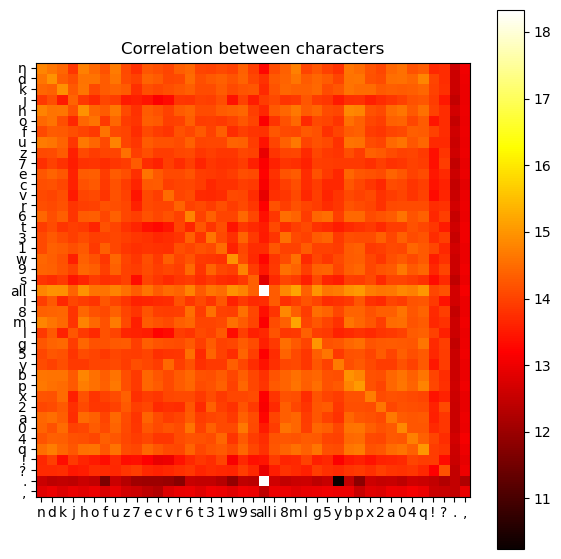

In [69]:
def correlation_heatmap(font):
    heatmap = [[np.log(correlation(font[char1], font[char2]).max()) for char2 in font] for char1 in font]
    plt.figure(figsize=(7, 7))
    plt.yticks(range(len(font)), font.keys())
    plt.xticks(range(len(font)), font.keys())
    plt.title('Correlation between characters')
    plt.colorbar(plt.imshow(heatmap, cmap='hot'))
    plt.show()

correlation_heatmap(load_fonts()['serif'])

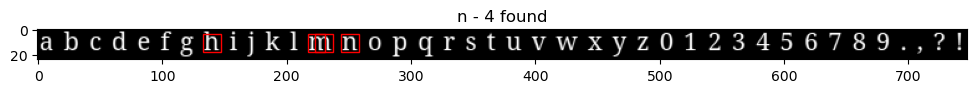

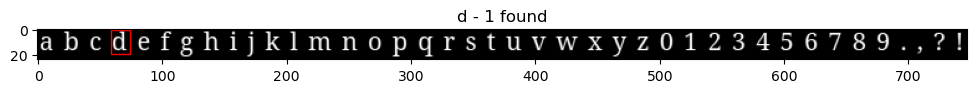

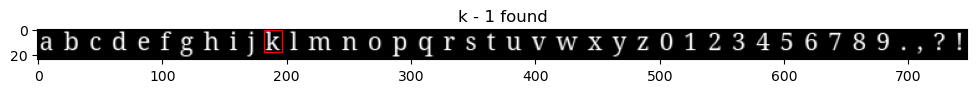

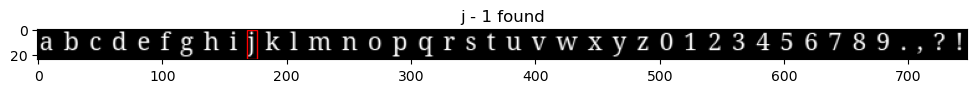

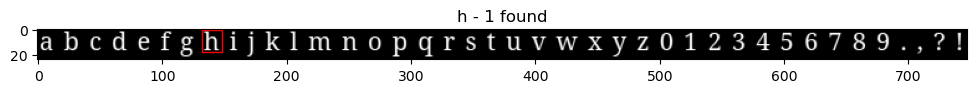

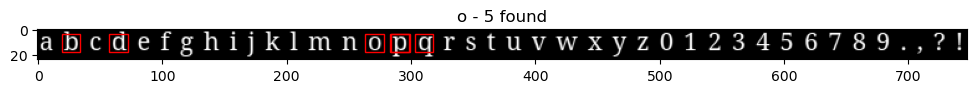

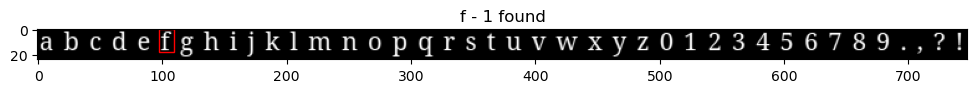

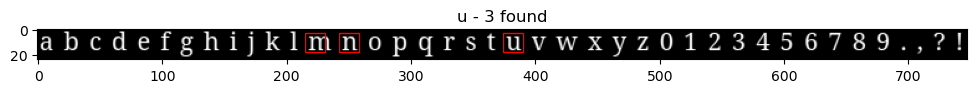

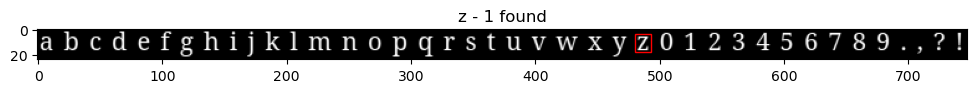

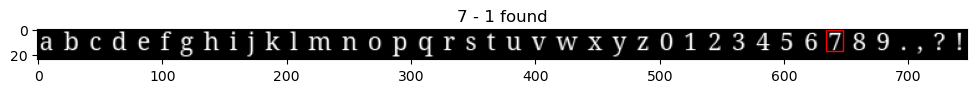

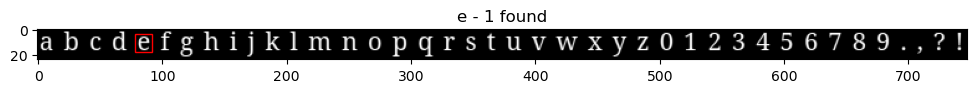

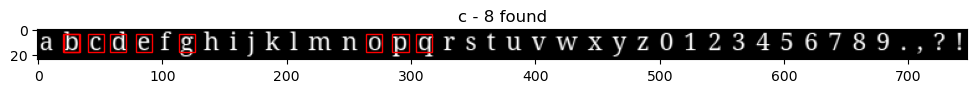

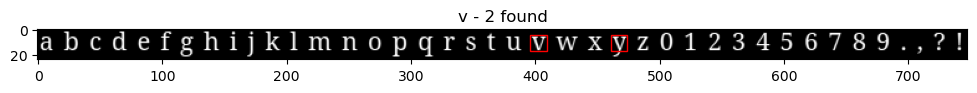

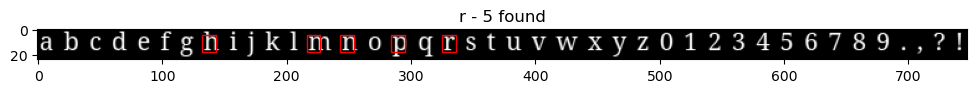

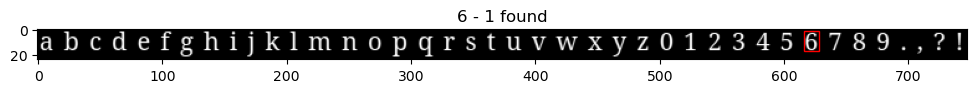

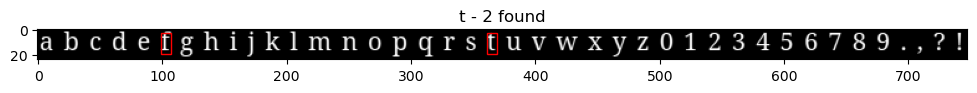

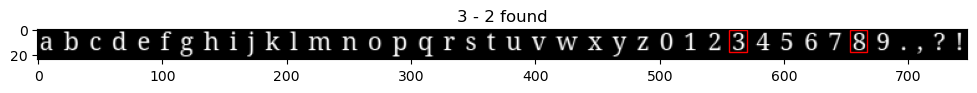

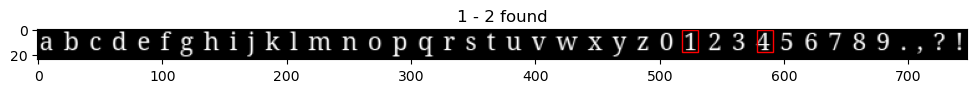

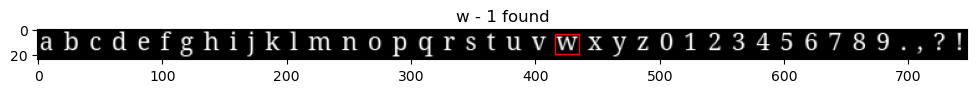

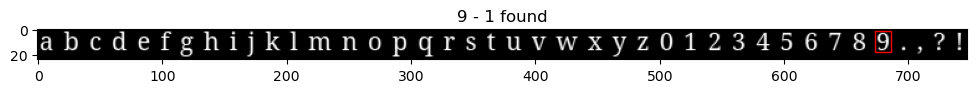

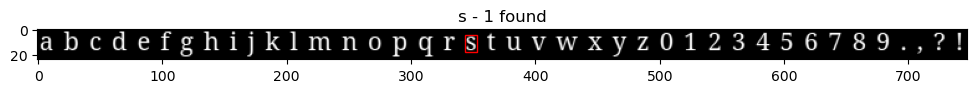

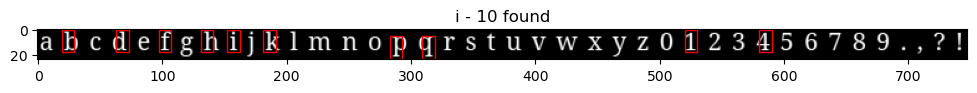

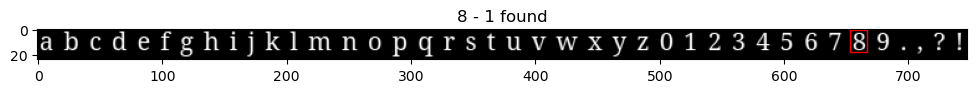

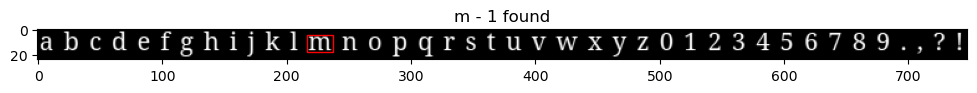

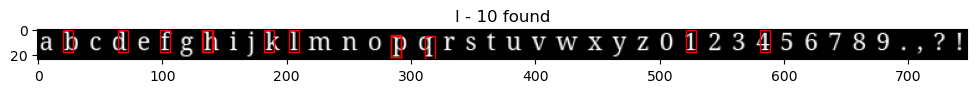

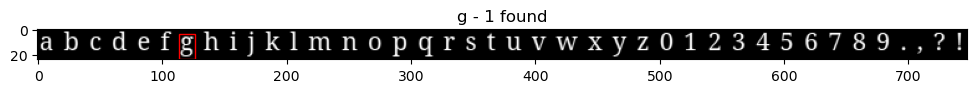

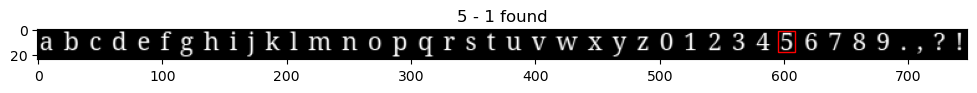

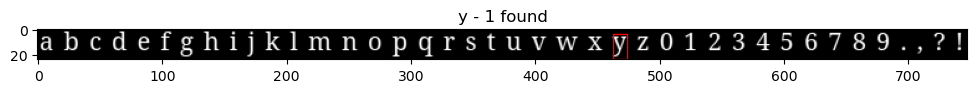

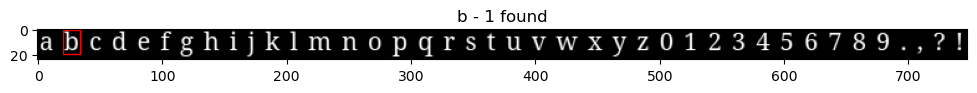

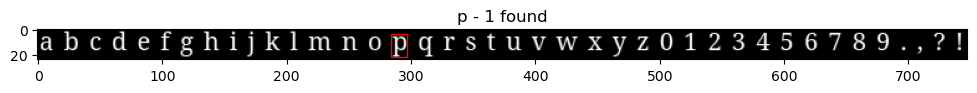

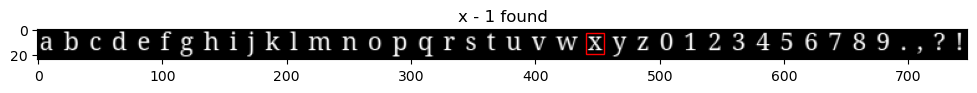

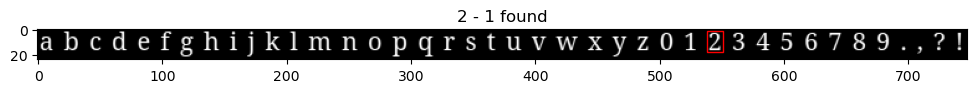

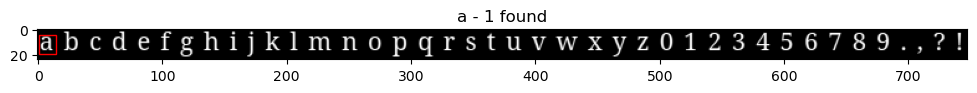

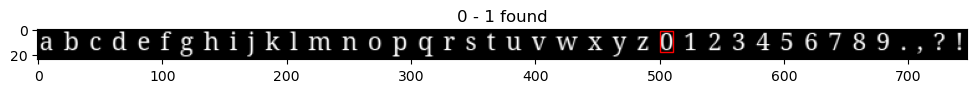

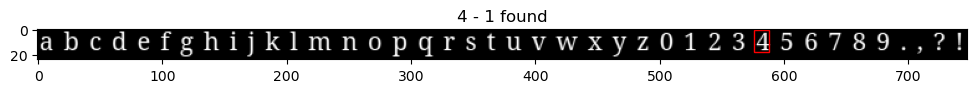

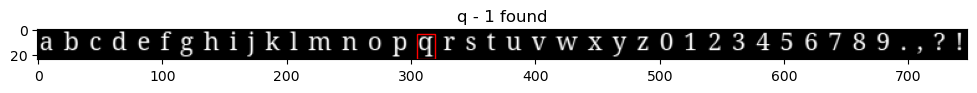

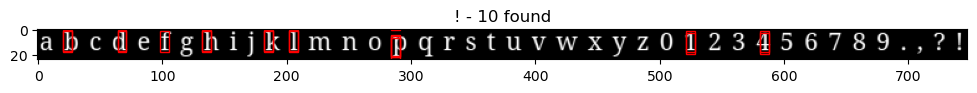

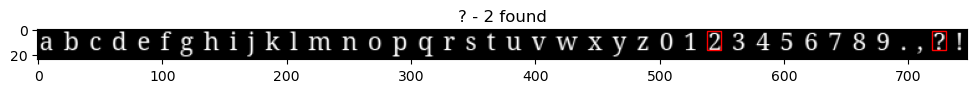

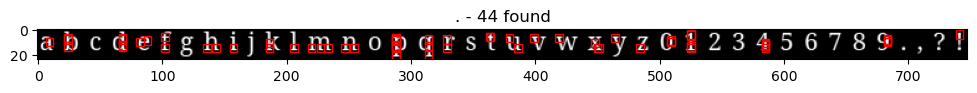

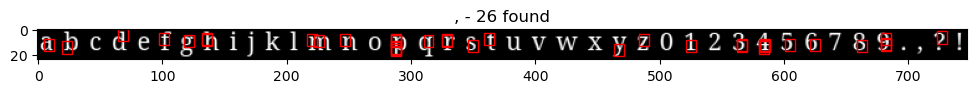

['d',
 'k',
 'j',
 'h',
 'f',
 'z',
 '7',
 'e',
 '6',
 'w',
 '9',
 's',
 '8',
 'm',
 'g',
 '5',
 'y',
 'b',
 'p',
 'x',
 '2',
 'a',
 '0',
 '4',
 'q',
 'v',
 't',
 '3',
 '1',
 '?',
 'n',
 'u',
 'o',
 'r',
 'c',
 'l',
 'i',
 '!',
 ',',
 '.']

In [70]:
def get_char_order(font, confidence=0.9, ratio=2, show=False):
    counter_dict = defaultdict(list)
    background = np.array(font['all'])

    for i, (char, img) in enumerate(font.items()):
        if char == 'all':
            continue
        sample = np.array(img)
        img_cor = correlation(background, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        count = len(measure.find_contours(img_cor, confidence*np.max(img_cor)))
        counter_dict[count].append(char)
    
        if show:
            _, ax = plt.subplots(figsize=(background.shape[0]//ratio, background.shape[1]//ratio))
            ax.set_title(f'{char} - {count} found')
            ax.imshow(background, cmap='gray')
            for i, j in np.argwhere(img_cor!=0.):
                ax.add_patch(patches.Rectangle((j,i), -sample.shape[1], -sample.shape[0], edgecolor='r', facecolor='none'))
            plt.show()
        
    result = []
    for key in sorted(counter_dict):
        result += counter_dict[key]
    
    rules = [('l', 'i'), ('h', 'b'), ('n', 'u'), ('6', '5')]
    for rule in rules:
        if result.index(rule[0]) > result.index(rule[1]):
            result[result.index(rule[0])], result[result.index(rule[1])] = result[result.index(rule[1])], result[result.index(rule[0])]
    return result

get_char_order(load_fonts()['serif'], show=True)

# Wykrywanie znaków

In [71]:
def display_overlayed(image, image_RGB, sample, title, confidence=0.89, ratio=10):
    fig, ax = plt.subplots(figsize=(image.shape[0]//ratio, image.shape[1]//ratio))
    ax.imshow(image_RGB, cmap='gray')
    img_cor = correlation(image, sample)
    img_cor[img_cor<np.max(img_cor)*confidence] = 0.
    for i, j in np.argwhere(img_cor!=0.):
        ax.add_patch(patches.Rectangle((j,i), -sample.shape[1], -sample.shape[0], edgecolor='r', facecolor='none'))
    found_pixels = len(measure.find_contours(img_cor, confidence*np.max(img_cor)))
    ax.set_title(f'{title} - {found_pixels} objects found')
    plt.show()

def read_text(image, font, confidence=0.89, show=False):
    char_order = get_char_order(font)
    enchanced = add_char_patterns(image, font)
    positions = []
    for char in char_order:
        sample = np.array(font[char])
        img_cor = correlation(enchanced, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        if show:
            display_overlayed(enchanced, enchanced, sample, char, confidence)
            #highlight_matches(enchanced, sample, char, np.argwhere(img_cor!=0.))
        for i, j in np.argwhere(img_cor!=0.):
            for x in range(1, sample.shape[0]):
                for y in range(1, sample.shape[1]):
                    enchanced[i-x, j-y] = 0
            positions.append((i, j, char))

    return positions       

# Podział na linie

In [72]:
def line_division(positions, lineheight=10):
    lines = defaultdict(list)
    for y, x, char in positions:
        for line in lines.keys():
            if abs(y - line) < lineheight:
                lines[line].append((x, char))
                break
        else:
            lines[y] = [(x, char)]
            
    return [line for _, line in sorted(lines.items())][:-1]

# Podział na słowa

In [73]:
def word_division(lines, font, charwidth=10):
    text = ""
    for line in lines:
        prev_x = min(line)[0]
        for i, (x, char) in enumerate(sorted(line)):
            if i > 0 and x - prev_x - font[char].size[0] >  charwidth:
                text += ' '
            elif i > 0 and x - prev_x < charwidth:
                continue
            text += char
            prev_x = x
        text += '\n'
        
    return text

# OCR

In [76]:
def ocr(imagepath, font):
    image = load_image(imagepath, invert=False)
    unnoised = remove_noise(image)
    rotated = rotate_image(unnoised)
    cropped = rotated.crop(rotated.getbbox())
    ready = ImageOps.invert(cropped)
    positions = read_text(ready, font)
    lines = line_division(positions)
    return word_division(lines, font, charwidth=3)

text = "butelka z woda i kieliszek z winem\n to co o 12.00 w nocy\n jest najwazniejsze."



1. 2. 3, 4, 5! oncc ! caught a fish aiive. 6, 7, 8. 9. 10
then , let it go again why did you let it go? hecause
it bit my finger so. which finge,. did it bite? th! , litt1e
tir.ger on my right.

Good: 182/192 Bad: 22/192 Total: 94.79%


---